In [1]:
from datetime import datetime
import numpy as np
from cpuinfo import get_cpu_info
from Tools.PlotTools import VisualTool
from Tools.MapLoader import MapLoader
from Tools.Mask import layer_map

In [2]:
vis=VisualTool(show=True, size=(5,5), save=False)

### Overview of Construction site map

In [3]:
map=MapLoader().load("seocho.crop2")

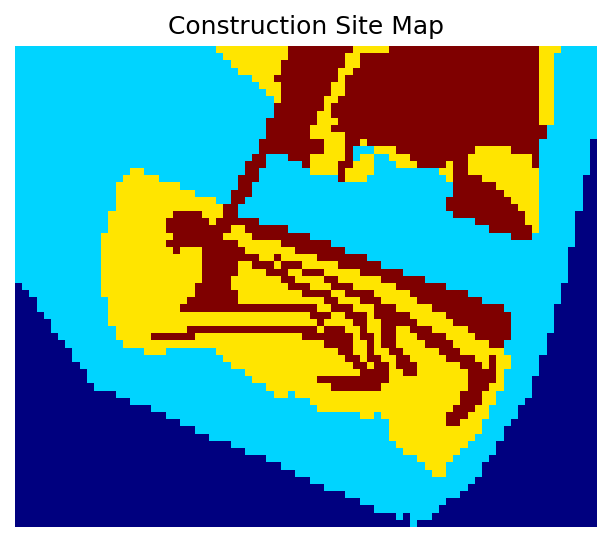

In [4]:
vis.showJetMap(map_data=map, title="Construction Site Map")

Installable map
<br><sub> A binary grid mask that defines physically feasible sensor deployment locations on the site. </sub>

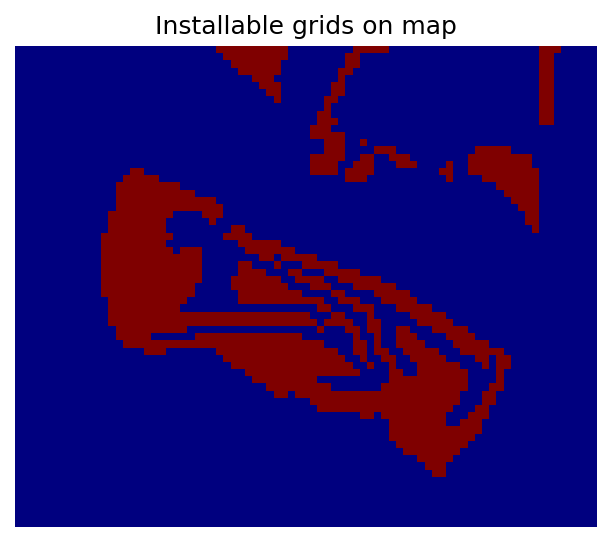

In [5]:
installable_layer = layer_map(map, keep_values=[2])
vis.showJetMap(map_data=installable_layer, title="Installable grids on map")

Uninstallable map
<br><sub>Regions excluded from sensor deployment due to safety, accessibility, or operational constraints <br>(e.g., equipment routes, waterlogged areas, vegetation, and offices).</sub>

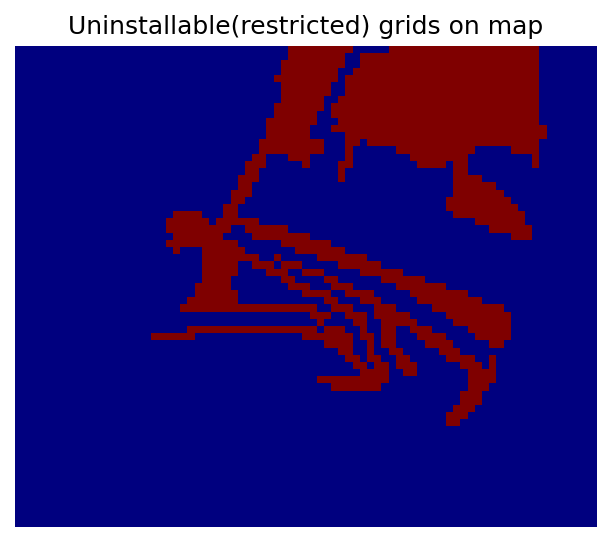

In [6]:
road_layer = layer_map(map, keep_values=[3])
vis.showJetMap(map_data=road_layer, title="Uninstallable(restricted) grids on map")

Jobsite area
<br><sub>The coverage target area for sensor deployment, defined as the union of installable and non-installable regions.</sub>

========== MAP CHECK ==========
Map shape (H,W): 67 x 81
Grid size: 5.0m x 5.0m  |  Cell area: 25.0 m^2
--------------------------------
Total cells: 5,427
Total area : 135,675.00 m^2  |  13.5675 ha  |  0.135675 km^2
--------------------------------
Target value      : 1
Target area       : 51,650.00 m^2  |  5.1650 ha  |  0.051650 km^2
Target cells      : 2,066  (38.07%)
--------------------------------
Value counts (entire map):
  - value 0: 3,361 (61.93%)
  - value 1: 2,066 (38.07%)


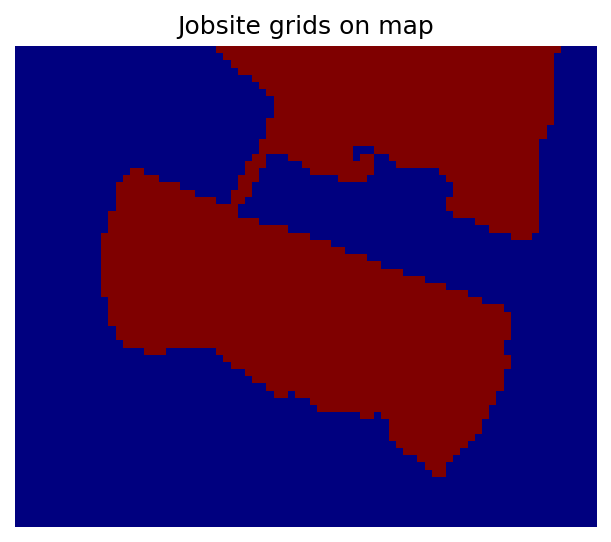

In [7]:
jobsite_layer = layer_map(map, keep_values=[2,3])
vis.map_check(map_data=jobsite_layer,title="Jobsite grids on map", return_stats=False)

### Systematic sensor deployment

In [8]:
#Set sensor coverage radius
COVERAGE = 45

Outermost corner location candidate extraction
<br><sub> Detection of outermost feasible sensor placement candidates within installable regions, since environmental sensing modules must be deployed at the site boundaries to capture extreme conditions. </sub>

Outmost corner points: 11


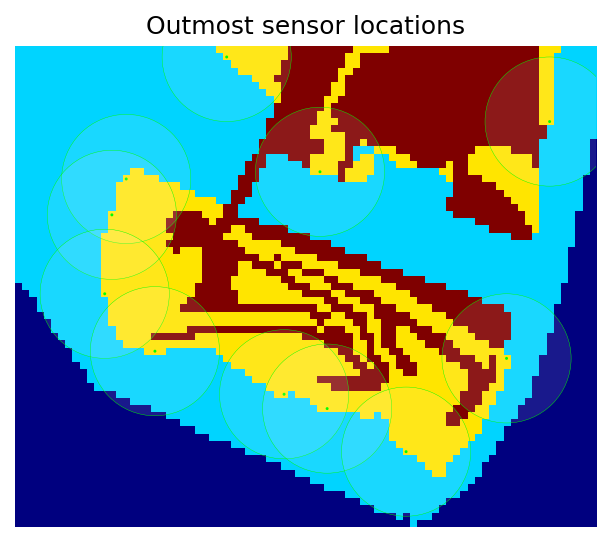

In [9]:
from OuterDeployment.HarrisCorner import HarrisCorner

corner_layer = HarrisCorner(jobsite_layer)
corner_candidate = corner_layer.run(
    grid=jobsite_layer,                
    installable_layer=installable_layer, 
    blockSize=3,
    ksize=3,
    k=0.01,
    dilate_size=5,
    min_dist=5,
)

print("Outmost corner points:", len(corner_candidate))
vis.showJetMap_circle(map_data=map, sensor_positions=corner_candidate, title="Outmost sensor locations",radius=COVERAGE)

Inner-Deployment Strategy: Genetic Algorithm
<br><sub>Genetic Algorithm is used to optimize the placement of inner sensors, minimizing the number of sensors while ensuring sufficient coverage of the jobsite area. </sub>

In [ ]:
from InnerDeployment.GeneticAlgorithm.main import SensorGA

ga = SensorGA(
                installable_map=installable_layer,
                jobsite_map=jobsite_layer,
                coverage=COVERAGE,
                generations=100,
                corner_positions=corner_candidate,
                initial_size=100,
                selection_size=50,
                child_chromo_size=100,
                min_sensors=50,
                max_sensors=100,
            )

optimized_result = ga.run(
                    selection_method="tournament",
                    mutation_rate=0.7,
                    early_stop=True,
                    early_stop_coverage=90.0,
                    early_stop_patience=5,
                    return_best_only=True
                )

[Gen:001/100] Fitness : (best=98.3543, avg=95.5494, worst=85.6244) | Coverage(best)=98.35% | Numb of sensors : (min=23, avg=27.2, max=31) | BestSensors=27 (corner=11)
[Profile Gen 001] fitness=57.036s | selection=0.000s | repro=0.577s (crossover=0.318s, mutation=0.258s) | calls: crossover~100, mutation~70.0
               fitness_breakdown: ordering=7.960s | score=49.073s | pop=100 

[Gen:002/100] Fitness : (best=97.6283, avg=92.7343, worst=84.5111) | Coverage(best)=97.63% | Numb of sensors : (min=21, avg=24.5, max=31) | BestSensors=27 (corner=11)
[Profile Gen 002] fitness=5.430s | selection=0.000s | repro=0.473s (crossover=0.235s, mutation=0.238s) | calls: crossover~100, mutation~70.0
               fitness_breakdown: ordering=0.553s | score=4.876s | pop=100 

[Gen:003/100] Fitness : (best=97.5315, avg=92.1709, worst=85.0920) | Coverage(best)=97.53% | Numb of sensors : (min=19, avg=23.4, max=31) | BestSensors=31 (corner=11)
[Profile Gen 003] fitness=4.550s | selection=0.000s | repro=0

In [ ]:
print("[FINALIZE OUTPUT] ga.best_solution =", ga.best_solution)
print("[FINALIZE OUTPUT] len(ga.best_solution) =", len(ga.best_solution))
print("[FINALIZE OUTPUT] ga.corner_points =", ga.corner_points)
print("[FINALIZE OUTPUT] len(ga.corner_points) =", len(ga.corner_points))

[FINALIZE OUTPUT] ga.best_solution = [(46, 62), (39, 38), (62, 63), (43, 53), (27, 9), (34, 25), (42, 66), (56, 61), (24, 2), (39, 45), (39, 29), (22, 14), (69, 60)]
[FINALIZE OUTPUT] len(ga.best_solution) = 13
[FINALIZE OUTPUT] ga.corner_points = [(14, 7), (23, 26), (23, 38), (26, 45), (57, 48)]
[FINALIZE OUTPUT] len(ga.corner_points) = 5


Total number of Sensor : 18


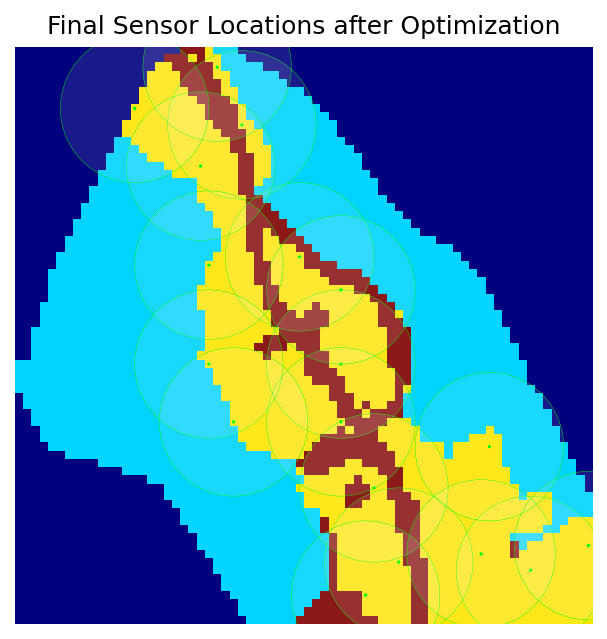

In [ ]:
final_result = optimized_result + corner_candidate
print("Total number of Sensor :", len(final_result))
vis.showJetMap_circle(
    map_data=map, 
    sensor_positions=final_result,
    title="Final Sensor Locations after Optimization",
    radius=COVERAGE
    )